# Discrete Fourier Transform
The discrete Fourier transform (DFT) of a time discrete signal $x(n)$ is evaluated over a block of length $N$:

$X(k)=\sum_{n=0}^{N-1} x(n)\cdot e^{-j2\pi nk/K}, 0\leq n<N$

In the following, we will assume, that the blocklength $N$ is equal to the transform lenght $K$: $N=K$.

The inverse algorithm is the inverse DFT:

$x(n) = \frac{1}{K}\sum_{k=0}^{K-1} X(k)\cdot e^{j2\pi nk/K}$.

The implementation of the DFT is usually called Fast Fourier Transform (FFT) and is part of most signal processing libraries. In the following, the equivalence between the DFT and the numpy version of the FFT is shown:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# define parameters and random input signal
N = 2**6
K = N
x = np.random.randn(N)

# test the DFT implementation
X = np.zeros(x.shape, dtype = complex)
for k in range(K):
    for n in range(N):
        X[k] += x[n] * np.exp(-1j*2*np.pi*n*k/K)
assert np.sum(np.abs(X - np.fft.fft(x))) < 1e-6, 'DFT and FFT are not equal'
# test the IDFT implementation
y = np.zeros((N), dtype = complex)
for n in range(N):
    for k in range(K):
        y[n] += X[k] * np.exp(1j*2*np.pi*n*k/K) / K
assert np.sum(np.abs(x - y)) < 1e-6, 'IDFT is not the inverse of the DFT'

print('evaluation done successfully')

evaluation done successfully


## Time resolution and frequency resolution
If the time resolution $T$ of the time discrete input data $x(n)$ is known, the frequency resolution of the DFT can be determined by the transform length $K$:

$\Delta f=\frac{1}{K\cdot T}$

The physical timestamp $t$ and the time discrete index $n$ has the following correspondency:

$t = n\cdot T$

The physical frequency and the frequency discrete index $k$ has the following correspondency:

$f = k\cdot\Delta f = \frac{k}{K\cdot T}$

This should be visualized by a sinus with $100$ Hz and a sampling rate of $\frac{1}{T}=1000$ Hz:

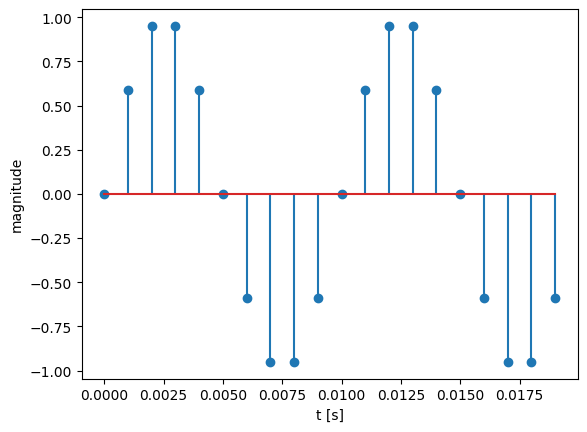

In [2]:
N = 20
K = N
SamplingRateInHertz = 1000
FrequencyInHertz = 100
PhysicalTimestamps = np.arange(N) / SamplingRateInHertz
SignalTimeDomain = np.sin(2*np.pi*FrequencyInHertz*PhysicalTimestamps)

plt.stem(PhysicalTimestamps, SignalTimeDomain)
plt.xlabel('t [s]')
plt.ylabel('magnitude')
plt.show()

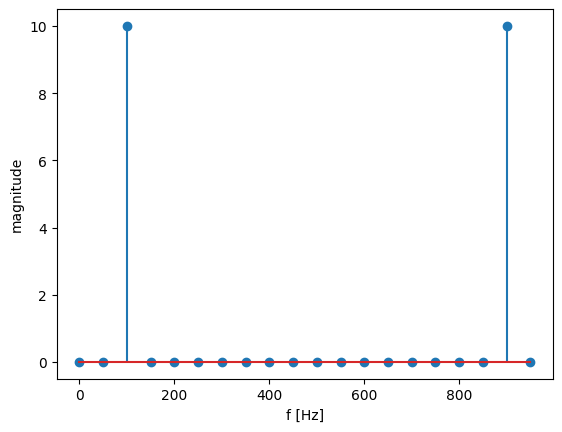

In [3]:
SignalFrequencyDomain = np.fft.fft(SignalTimeDomain, K)

Delta_f = SamplingRateInHertz / K
PhysicalFrequencies = np.arange(K) * Delta_f

plt.stem(PhysicalFrequencies, np.abs(SignalFrequencyDomain))
plt.xlabel('f [Hz]')
plt.ylabel('magnitude')
plt.show()

## Zero padding

The DFT is defined by

$X(k)=\sum_{n=0}^{N-1} x(n)\cdot e^{-j2\pi nk/K}$

with $0\leq n<N$ and $0\leq k < K$.
$N$ is the length of the time signal which is analysed and $K$ is the so-called transform length.

The frequency resolution of the DFT is evaluated by

$\Delta f=\frac{1}{KT}$ with $T$ equals to the sampling duration.

The frequency resolution can be increased by increasing $K$. If $K>N$, the DFT fills the signal $x(n)$ with $K-N$ zeros at the end. This is called zero-padding. The increased frequency resolution gives no additional information about the spectrum. Instead the underlying frequency continuous spectrum is sampled with a finer frequency resolution.

Zero padding has two motivations: Firstly, with zero padding it is possible to analyze a given frequency. Secondly, it is possible to use a transform length $K$, which is a power of $2$. Generally, this speed up the evaluation of the DFT.

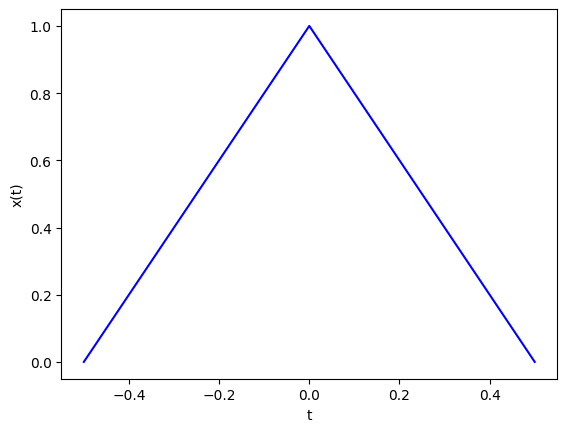

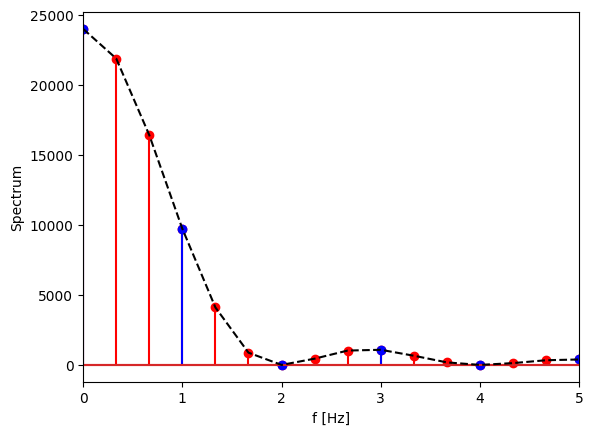

In [4]:
Fs = 48000
T = 1/Fs
t = np.arange(Fs)*T - 0.5 # one second of timestamps
#f = 2
#x = (np.cos(2*np.pi*f*t) > 0) + 1
x = 1 - np.abs(2*t)

plt.plot(t, x, 'b')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

def EvaluateSpectrum(x, K, Fs):
    X = np.fft.fft(x, K)
    NyquistIndex = int(K/2+1)
    X = np.abs(X[0:NyquistIndex])
    Deltaf = Fs/K
    f = np.arange(NyquistIndex) * Deltaf
    return X, f

N = x.shape[0]
X, f = EvaluateSpectrum(x, N, Fs)

#K = int(2**np.ceil(np.log2(N)))
K = 3*N
X_zeropadded, f_zeropadded = EvaluateSpectrum(x, K, Fs)

plt.stem(f_zeropadded, X_zeropadded, 'r')
plt.stem(f, X, 'b')
plt.plot(f_zeropadded, (np.sinc(0.5*f_zeropadded)**2)*X[0], '--k') # the true spectrum
plt.xlim(0, 5)
plt.xlabel('f [Hz]')
plt.ylabel('Spectrum')
plt.show()

## Symmetry
If the input data is real valued, the output data is symmetric to the half of the sampling frequency:

$X(k) = X^*(K-k)$

For reducing the memory consumption, the second half symmetric part of the spectrum is usually dropped for further analysis, because it is redundant.
The highest index, which has to be kept for analysis is the index of the Nyquist-frequency: $f_\text{Nyquist} = \frac{r}{2}$.

The zero-th index corresponds to the frequency $f=0$ Hz, which is nothing else than the DC-part of the signal. For even values of $K$, the element at the Nyquist-frequency is the real part of the underlying spectrum, due to the symmetry-condition at this point:

$X\left(k_\text{Nyquist}\right)=X^*\left(k_\text{Nyquist}\right)$

In [5]:
N = int(np.random.rand(1) * 1000)
K = int(2**np.ceil(np.log2(N)))

x = np.random.randn(N)
X = np.fft.fft(x, K)

for k in range(1, K):
    assert np.abs(X[k] - np.conj(X[K-k])) < 1e-10, 'error in DFT symmetry'
    
NyquistIndex = K // 2 + 1
X_FirstHalfOfSpectrum = X[0:NyquistIndex]
Y = np.zeros((K), dtype = complex)
for k in range(K):
    if k < X_FirstHalfOfSpectrum.shape[0]:
        Y[k] = X_FirstHalfOfSpectrum[k]
    else:
        Y[k] = np.conj(Y[K- k])
assert np.sum(np.abs(X - Y)) < 1e-6, 'wrong reconstruction of second symmetric part of the spectrum'

## Parsevals theorem
The Parseval theorem for continuous signals states, that the energy can be evaluated in time domain $x(t)$ or in frequency domain $X(f)$. This is also true for the DFT, with the exception of a scaling factor $\frac{1}{K}$:

$E=\sum_{n=0}^{N-1} \left|x(n)\right|^2=\frac{1}{K}\sum_{k=0}^{K-1}\left|X(k)\right|^2$

In the case of even values of $K$ the Parseval theorem for the first part of the spectrum cannot be fullfilled exactly: For the Nyquist frequency, the imaginary part is lost. Therefore, the Parseval-theorem is not fullfilled exactly in the case of even values of $K$.

In [6]:
N = int(np.random.rand(1) * 1000)
K = N + int(np.random.rand(1) * 1000)

x = np.random.randn(N)
X = np.fft.fft(x, K)

# Parsevals theorem for full spectrum
E_x = np.sum(np.abs(x)**2)
E_X = np.sum(np.abs(X)**2) / K
assert np.abs(E_x - E_X)< 1e-10, 'error in evaluation of Parsevals theorem'

# Parseval theorem for half spectrum
NyquistIndex = K // 2 + 1
X_FirstHalfOfSpectrum = X[0:NyquistIndex]
X2_FirstHalfOfSpectrum = np.abs(X_FirstHalfOfSpectrum)**2
X2_FirstHalfOfSpectrum[1:] *= 2
E_X = np.sum(X2_FirstHalfOfSpectrum) / K
if (K % 2) == 1:
    assert np.abs(E_X - E_x) < 1e-10, 'error in evaluation of Parseval theorem for first half of spectrum'

## Periodicity
The DFT or FFT assumes a periodical signal. The assumption of periodicity of the input signal lead to problems, if the signal to be analysed does not correspond to a whole period of the signal, i.e. $N$ is not an integer multiple of the period length. In these cases, the beginning and ending of the block of length $N$ are njot matching. This behaviour is visualized by two signals: $x(n)$ contains a whole period (or an integer number of periods) and $y(n)$ does not contain a whole period. The spectrum of $y(n)$ is plotted in red and contains a large amount of signal energy beside the maximum at 10 Hz. This large amount of energy beside the maximum is called frequency smearing of the DFT.

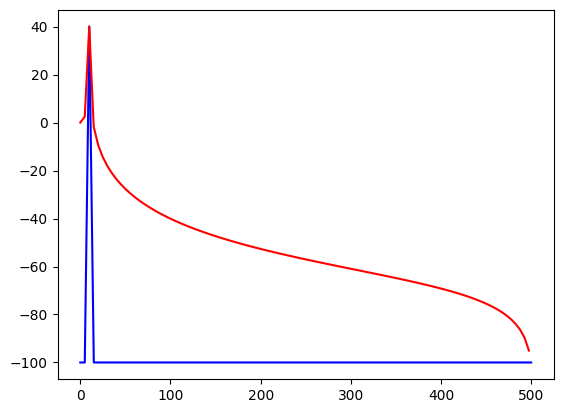

In [7]:
def EvaluateSpectrum(x, Fs):
    X = np.fft.fft(x)
    NyquistIndex = int(X.shape[0]/2+1)
    X = np.abs(X[0:NyquistIndex])
    f = np.arange(X.shape[0])/x.shape[0]*Fs
    X_level = 20*np.log10(X + 1e-5)
    return X_level, f

Fs = 1000
f = 10
n = np.arange(int(2*Fs/f))
x = np.cos(2*np.pi*f*n/Fs)
n = np.arange(int(2*Fs/f+1))
y = np.cos(2*np.pi*f*n/Fs)

X, f_x = EvaluateSpectrum(x, Fs)
Y, f_y = EvaluateSpectrum(y, Fs)

plt.plot(f_x, X, 'b')
plt.plot(f_y, Y, 'r')
plt.show()

## Window function
One workaround for the requirement of periodicity is to use a window function $w(n)$ which is element-wise multiplied with the signal to be analysed $x(n)$. These window functions realises a fade in and fade out of the signal $x(n)$. A commonly used window function is the Hann window:

$w(n) = \frac{1}{2}\left(1-\cos\left(2\pi \frac{n + 0.5}{N}\right)\right)$

There exists a big bunch of different window functions. Most of them has a unique maximum in the middle and they are fading in and fading out to the left and right ending of the window function.

Therefore, in frequency domain these window functions are lowpasses.

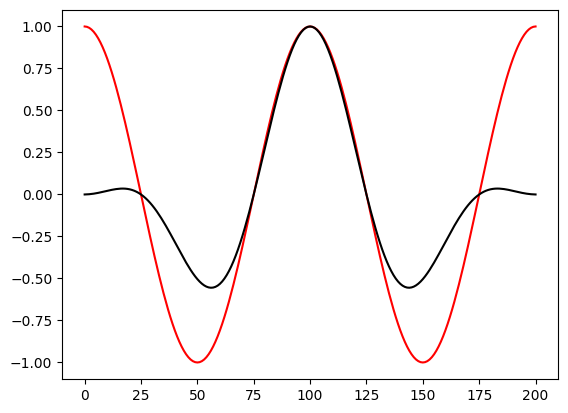

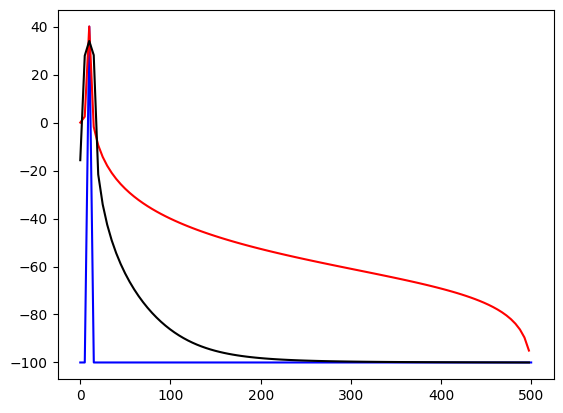

In [8]:
def HannWindow(N):
    n = np.arange(N)
    return 0.5 * (1 - np.cos(2*np.pi*(n+0.5)/N))

w = HannWindow(y.shape[0])
y_windowed = y * w

plt.plot(n, y, 'r')
plt.plot(n, y_windowed, 'k')
plt.show()

Y_windowed, f_y = EvaluateSpectrum(y_windowed, Fs)

plt.plot(f_x, X, 'b')
plt.plot(f_y, Y, 'r')
plt.plot(f_y, Y_windowed, 'k')
plt.show()

## Programming exercise:

The DFT algorithm can be described by a matrix multiplication:

$X(k)=\sum_{n=0}^{N-1} x(n)\cdot e^{-j2\pi nk/K}, 0\leq n<N$

$\rightarrow X=T_\text{DFT}\cdot x$

1) Evaluate the transform matrix $T_\text{DFT}$ in the procedure DFTByMatrixMultiplication.
2) Implement the option of zero padding ($K > N$) in the procedure DFTByMatrixMultiplication.
3) The multiplication with the window function HannWindow(N) can also explained by a matrix multiplication. Implement the corresponding procedure WindowingByMatrixMultiplication.
4) Both operations windowing and DFT can be combined in a single matrix multiplication. I

In [10]:
def DFTByMatrixMultiplication(N, K = None):
    ### solution
    if K is None:
        K = N
    n = np.arange(N)
    k = np.arange(K)
    T = np.exp(-1j*2*np.pi*np.outer(k, n)/K)
    ### solution
    return T

def WindowingByMatrixMultiplication(N):
    ### solution
    w = HannWindow(N)
    T = np.zeros((N, N))
    for n in range(N):
        T[n, n] = w[n]
    ### solution
    return T

def WindowingAndDFTByMatrixMultiplication(N, K = None):
    ### solution
    T_w = WindowingByMatrixMultiplication(N)
    T_DFT = DFTByMatrixMultiplication(N, K)
    T = np.matmul(T_DFT, T_w)
    ### solution
    return T

import unittest

class TestProgrammingExercise(unittest.TestCase):

    def test_DFTByMatrixMultiplication(self):
        N = np.random.randint(1000) + 1
        x = np.random.randn(N)
        T = DFTByMatrixMultiplication(N)
        y1 = np.matmul(T, x)
        y2 = np.fft.fft(x)
        self.assertGreater(10*np.log10(np.sum(np.abs(y2)**2)/np.sum(np.abs(y1-y2)**2+1e-16)), 100)

    def test_DFTByMatrixMultiplicationZeroPadding(self):
        N = np.random.randint(1000) + 1
        K = int(2**np.ceil(np.log2(N)))
        x = np.random.randn(N)
        T = DFTByMatrixMultiplication(N, K)
        y1 = np.matmul(T, x)
        y2 = np.fft.fft(x, n = K)
        self.assertGreater(10*np.log10(np.sum(np.abs(y2)**2)/np.sum(np.abs(y1-y2)**2+1e-16)), 100)

    def test_WindowingByMatrixMultiplication(self):
        N = np.random.randint(1000) + 1
        K = N + np.random.randint(10)
        x = np.random.randn(N)
        w = HannWindow(N)
        T = WindowingByMatrixMultiplication(N)
        y1 = np.matmul(T, x)
        y2 = x*w
        self.assertGreater(10*np.log10(np.sum(np.abs(y2)**2)/np.sum(np.abs(y1-y2)**2+1e-16)), 100)

    def test_WindowingAndDFTByMatrixMultiplication(self):
        N = np.random.randint(1000) + 1
        K = N + np.random.randint(10)
        x = np.random.randn(N)
        w = HannWindow(N)
        T = WindowingAndDFTByMatrixMultiplication(N)
        y1 = np.matmul(T, x)
        y2 = np.fft.fft(x*w)
        self.assertGreater(10*np.log10(np.sum(np.abs(y2)**2)/np.sum(np.abs(y1-y2)**2+1e-16)), 100)
    
unittest.main(argv=[''], verbosity=2, exit=False)

test_DFTByMatrixMultiplication (__main__.TestProgrammingExercise.test_DFTByMatrixMultiplication) ... ok
test_DFTByMatrixMultiplicationZeroPadding (__main__.TestProgrammingExercise.test_DFTByMatrixMultiplicationZeroPadding) ... ok
test_WindowingAndDFTByMatrixMultiplication (__main__.TestProgrammingExercise.test_WindowingAndDFTByMatrixMultiplication) ... ok
test_WindowingByMatrixMultiplication (__main__.TestProgrammingExercise.test_WindowingByMatrixMultiplication) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.172s

OK


## Exam preparation
1) Prove the symmetry of the DFT: $X(k) = X^*(K-k)$.

2) A sinus with $f=440$ Hz and amplitude $\hat x = 1$ is sampled with a sampling rate of $r=1$ kHz. Evaluate the first three samples $x(n)$. Evaluate the result of the DFT over the first three samples with $N=K=3$. Evaluate the energy in the time domain and in the frequency domain.

3) A signal has a sampling rate of $r=48$ kHz. The DFT uses a block length of $N=1000$ and a transform length of $K=1024$. Evaluate the frequency resolution $\Delta f$. Is zero-padding used? Which index $k$ corresponds to $f=50$ Hz? How many indices can be dropped after transform due to the symmetry?

4) Give a list of advantages and disadvantages of the DFT.